# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [19]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn

In [20]:

train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [21]:
train[0][0].shape

torch.Size([1, 28, 28])

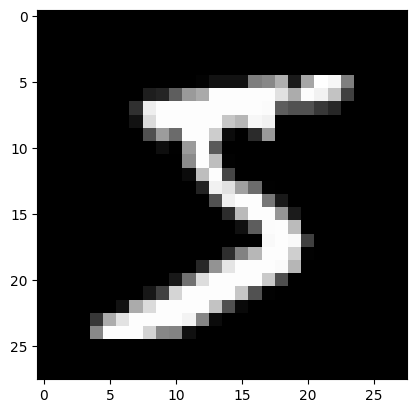

In [22]:

plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

In [23]:
#augmentations:rotation,affine(translate + shear),perspective,resized crop,gaussian blur,horizontal flip
augment = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(28, scale=(0.8,1.0)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])




In [24]:
#MNIST dataset with augmentations
augmented_ds = datasets.MNIST(
    root='data',
    train=True,
    transform=augment,
    download=False
)

#ample a batch of 6 augm. imgs
loader = DataLoader(augmented_ds, batch_size=6, shuffle=True)
batch, _ = next(iter(loader))



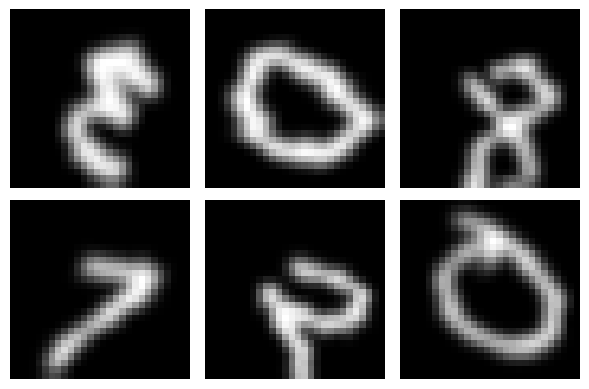

In [25]:
#plot
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
for img, ax in zip(batch, axes.flatten()):
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [26]:
#data loader
train_dataset = datasets.MNIST(root='data', train=True, download=False, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [27]:
#Define MLP Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #Encoder: 784 -> 128 -> 64
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        #Decoder: 64-> 128 --> 784
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),                  # da input pixels ∈ [0,1]
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [28]:
#model, loss & optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()                #MSE between input and reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Training loop
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        loss = criterion(recon, imgs)    # identity loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch:2d}/{n_epochs} — Loss: {epoch_loss:.6f}')


Epoch  1/50 — Loss: 0.051150
Epoch  2/50 — Loss: 0.021641
Epoch  3/50 — Loss: 0.016210
Epoch  4/50 — Loss: 0.013594
Epoch  5/50 — Loss: 0.011775
Epoch  6/50 — Loss: 0.010492
Epoch  7/50 — Loss: 0.009577
Epoch  8/50 — Loss: 0.008913
Epoch  9/50 — Loss: 0.008405
Epoch 10/50 — Loss: 0.007999
Epoch 11/50 — Loss: 0.007660
Epoch 12/50 — Loss: 0.007354
Epoch 13/50 — Loss: 0.007065
Epoch 14/50 — Loss: 0.006795
Epoch 15/50 — Loss: 0.006569
Epoch 16/50 — Loss: 0.006349
Epoch 17/50 — Loss: 0.006152
Epoch 18/50 — Loss: 0.005988
Epoch 19/50 — Loss: 0.005835
Epoch 20/50 — Loss: 0.005689
Epoch 21/50 — Loss: 0.005574
Epoch 22/50 — Loss: 0.005467
Epoch 23/50 — Loss: 0.005383
Epoch 24/50 — Loss: 0.005308
Epoch 25/50 — Loss: 0.005225
Epoch 26/50 — Loss: 0.005151
Epoch 27/50 — Loss: 0.005078
Epoch 28/50 — Loss: 0.005018
Epoch 29/50 — Loss: 0.004947
Epoch 30/50 — Loss: 0.004877
Epoch 31/50 — Loss: 0.004833
Epoch 32/50 — Loss: 0.004785
Epoch 33/50 — Loss: 0.004742
Epoch 34/50 — Loss: 0.004709
Epoch 35/50 — 

Loss fällt --> NEtz lern (irgendwas aufjedenfall! XD)

## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [29]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [30]:
#Create noisy MNIST dataset
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.5)
])
clean_transform = transforms.ToTensor()

noisy_dataset = datasets.MNIST(root='data', train=False, download=False, transform=noise_transform)
clean_dataset = datasets.MNIST(root='data', train=False, download=False, transform=clean_transform)

noisy_loader = DataLoader(noisy_dataset, batch_size=6, shuffle=True)
clean_loader = DataLoader(clean_dataset, batch_size=6, shuffle=True)


In [31]:

#Load trained autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

#get one batch
noisy_imgs, _ = next(iter(noisy_loader))
clean_imgs, _ = next(iter(clean_loader))
noisy_imgs = noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

In [32]:

#Denoising it
with torch.no_grad():
    denoised_imgs = model(noisy_imgs)

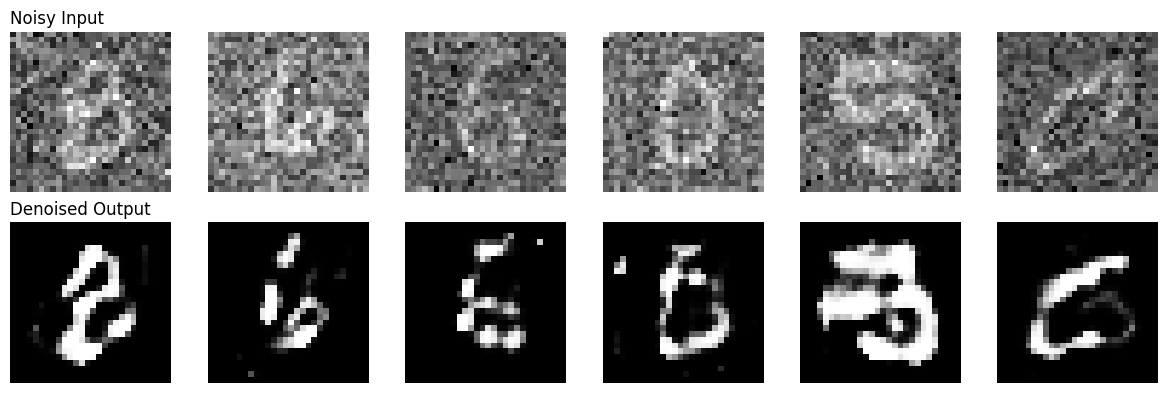

In [33]:



#plot
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i in range(6):
    axes[0, i].imshow(noisy_imgs[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(denoised_imgs[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title('Noisy Input', loc='left')
axes[1, 0].set_title('Denoised Output', loc='left')
plt.tight_layout()
plt.show()


## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

Adjusted Rand Index (ARI):          0.1786
Normalized Mutual Info (NMI):       0.2774
Silhouette Score:                   0.0687
Cluster Purity:                     0.3905


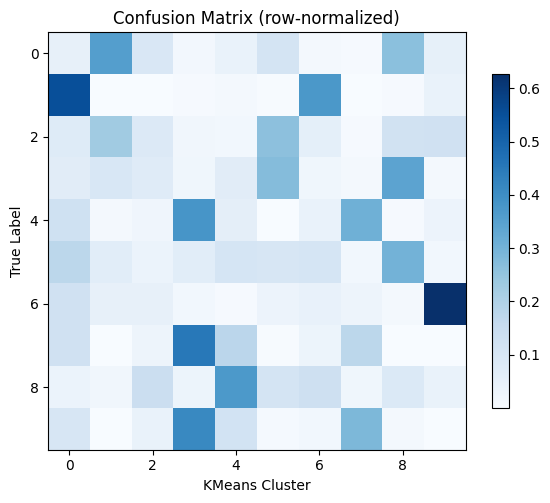

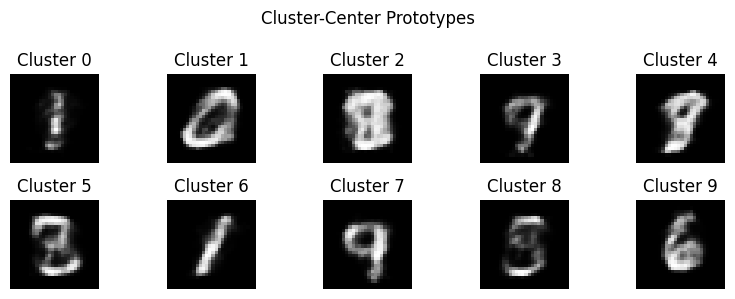

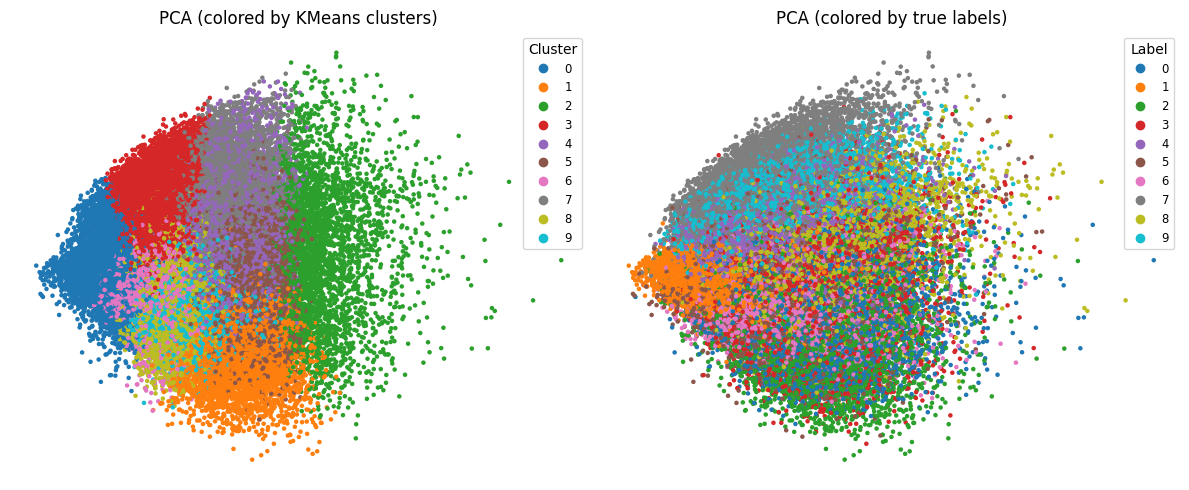

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    confusion_matrix
)
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1. Prepare DataLoader (raw MNIST → [0,1] tensors)
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# 2. Extract latent representations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

latents = []
labels = []
with torch.no_grad():
    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        z = model.encoder(imgs)                  # encoder output shape [B, latent_dim]
        latents.append(z.cpu().numpy())
        labels.append(lbls.numpy())

latents = np.vstack(latents)                    # shape (60000, latent_dim)
labels  = np.hstack(labels)                     # shape (60000,)

# 3. K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
preds = kmeans.fit_predict(latents)

# 4. Compute evaluation metrics
ari      = adjusted_rand_score(labels, preds)
nmi      = normalized_mutual_info_score(labels, preds)
sil      = silhouette_score(latents, preds)
# purity
purity = sum(
    np.bincount(labels[preds == i]).max()
    for i in range(10)
) / labels.size

print(f"Adjusted Rand Index (ARI):          {ari:.4f}")
print(f"Normalized Mutual Info (NMI):       {nmi:.4f}")
print(f"Silhouette Score:                   {sil:.4f}")
print(f"Cluster Purity:                     {purity:.4f}")

# 5. Confusion matrix (true vs. predicted clusters)
cm = confusion_matrix(labels, preds, normalize='true')  # row-normalized
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar(shrink=0.8)
plt.xlabel("KMeans Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()

# 6. Prototype images: decode cluster centers
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
with torch.no_grad():
    protos = model.decoder(centers)      # shape [10,1,28,28]
protos = protos.cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 5, figsize=(8,3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(protos[i], cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.suptitle("Cluster-Center Prototypes")
plt.tight_layout()
plt.show()

# 7. PCA for 2D visualization
pca = PCA(n_components=2, random_state=0)
Z2 = pca.fit_transform(latents)

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
scatter = ax[0].scatter(Z2[:,0], Z2[:,1], c=preds, s=5, cmap='tab10')
ax[0].set_title("PCA (colored by KMeans clusters)")
ax[0].axis('off')
ax[0].legend(*scatter.legend_elements(), title="Cluster", loc="upper right", fontsize="small")

scatter2 = ax[1].scatter(Z2[:,0], Z2[:,1], c=labels, s=5, cmap='tab10')
ax[1].set_title("PCA (colored by true labels)")
ax[1].axis('off')
ax[1].legend(*scatter2.legend_elements(), title="Label", loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()
